In [1]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import calendar

from dateutil.relativedelta import relativedelta

In [2]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,tipo):

     if tipo=='WeekDay':
          return row['Fecha'].weekday()
     
     elif tipo=='WeekMonth':
          return (row['Fecha'].day - 1) // 7 + 1
     
     elif tipo=='DayType':
          if row['Fecha'] in co_holidays:
               return 'F'
          elif row['Fecha'].weekday()==5:
               return 'S'
          elif row['Fecha'].weekday()==6:
               return 'F'
          else:
               return 'O'

In [3]:
# Lectura de datos de enrtrada para el cálculo
s_parentpath=Path(r'C:\Alejo\Eje de Planeación\Análisis Energético\ProyecciónUnidad260MW')
filepath=s_parentpath.joinpath(s_parentpath,'Resultados.xlsx')

l_sheets=['29_31','32_34','35_37','38_40','41_43']

l_yearIni=[2029,2032,2035,2038,2041]
l_yearFin=[2031,2034,2037,2040,2043]

df_GenTri = pd.DataFrame()

for i in range(0,5):
    # Carga de cada hoja de Excel
    sheet_name=l_sheets[i]
    df_res=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

    yearIni=l_yearIni[i]
    yearFin=l_yearFin[i]

    fechaIni=dt.datetime(yearIni,1,1)
    fechaFin=dt.datetime(yearFin,12,31)

    fecha=fechaIni

    fecha=fecha + dt.timedelta(days=1) 

    while fecha<=fechaFin:

        iDay=fecha.day

        if iDay==2:
            df_res1=df_res[(pd.to_datetime(df_res.Fecha)==fecha)][['Fecha','periodo','TEBSA260']]
            df_res1['day_osf']='S'
            df_res1=df_res1.reset_index(drop=True)
        elif iDay==3:
            df_res1=df_res[(pd.to_datetime(df_res.Fecha)==fecha)][['Fecha','periodo','TEBSA260']]
            df_res1['day_osf']='F'
            df_res1=df_res1.reset_index(drop=True)
        else:
            df_res1=df_res[(pd.to_datetime(df_res.Fecha)>=fecha) & (pd.to_datetime(df_res.Fecha)<=(fecha+dt.timedelta(days=1)))][['Fecha','periodo','TEBSA260']]
            df_res1=df_res1.groupby(['periodo'])[['TEBSA260']].max()
            df_res1=df_res1.reset_index()
            df_res1['Fecha']=fecha
            df_res1=df_res1[['Fecha','periodo','TEBSA260']]
            df_res1['day_osf']='O'
            df_res1=df_res1.reset_index(drop=True)
            df_res1['Fecha'] = df_res1['Fecha'].astype('datetime64[ns]')
        
        df_GenTri=pd.concat([df_GenTri,df_res1],axis=0, ignore_index=True)
        
        if iDay==4:
            fecha = fecha + relativedelta(months=1)
            deltaD=dt.timedelta(days=-2)
            fecha=fecha + deltaD
        else:    
            fecha=fecha + dt.timedelta(days=1)       


In [4]:
df_GenTri['mes']=df_GenTri['Fecha'].dt.month
df_GenTri['year']=df_GenTri['Fecha'].dt.year
df_GenTri = df_GenTri.drop(['Fecha'], axis=1)


In [5]:
df_GenTri

,periodo,TEBSA260,day_osf,mes,year
0,1,0.0,S,1,2029
1,2,0.0,S,1,2029
2,3,0.0,S,1,2029
3,4,0.0,S,1,2029
4,5,0.0,S,1,2029
...,...,...,...,...,...
12955,20,260.0,O,12,2043
12956,21,260.0,O,12,2043
12957,22,190.0,O,12,2043
12958,23,120.0,O,12,2043


In [6]:
# Generar dataframe con los registrso de todos los años
fechaIni=dt.datetime(2029,1,1)
fechaFin=dt.datetime(2043,12,31)

# Crear un rango de fechas diario
fechas = pd.date_range(start=fechaIni, end=fechaFin, freq='D')

# Crear un dataframe con todas las combinaciones de fecha y periodo (1 a 24)
df_dias_periodos = pd.DataFrame(
    [(fecha, periodo) for fecha in fechas for periodo in range(1, 25)],
    columns=['Fecha', 'periodo']
)

# Definir tipo de día
df_dias_periodos['day_osf']=df_dias_periodos.apply(lambda row: typedays(row,tipo='DayType'),axis=1)

In [7]:
df_dias_periodos

,Fecha,periodo,day_osf
0,2029-01-01,1,F
1,2029-01-01,2,F
2,2029-01-01,3,F
3,2029-01-01,4,F
4,2029-01-01,5,F
...,...,...,...
131467,2043-12-31,20,O
131468,2043-12-31,21,O
131469,2043-12-31,22,O
131470,2043-12-31,23,O


In [8]:
df_dias_periodos['mes']=df_dias_periodos['Fecha'].dt.month
df_dias_periodos['year']=df_dias_periodos['Fecha'].dt.year

In [9]:
df_data=df_dias_periodos.merge(df_GenTri,left_on=['periodo','day_osf','mes','year'],right_on=['periodo','day_osf','mes','year'],how='left')[['Fecha','periodo','day_osf','mes','year','TEBSA260']]

In [10]:
df_data['TEBSA260_diff'] = df_data['TEBSA260'] - df_data['TEBSA260'].shift(-1)
df_data['Arranques'] = (df_data['TEBSA260_diff'] == -50).astype(int)
df_data['IsGen'] = (df_data['TEBSA260'] > 0).astype(int)
df_data

,Fecha,periodo,day_osf,mes,year,TEBSA260,TEBSA260_diff,Arranques,IsGen
0,2029-01-01,1,F,1,2029,0.0,0.0,0,0
1,2029-01-01,2,F,1,2029,0.0,0.0,0,0
2,2029-01-01,3,F,1,2029,0.0,0.0,0,0
3,2029-01-01,4,F,1,2029,0.0,0.0,0,0
4,2029-01-01,5,F,1,2029,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
131467,2043-12-31,20,O,12,2043,260.0,0.0,0,1
131468,2043-12-31,21,O,12,2043,260.0,70.0,0,1
131469,2043-12-31,22,O,12,2043,190.0,70.0,0,1
131470,2043-12-31,23,O,12,2043,120.0,0.0,0,1


In [20]:
df_data_per=df_data.groupby(['year'])[['TEBSA260','Arranques','IsGen']].sum()
df_data_per=df_data_per.reset_index()
df_data_per['TEBSA260']=df_data_per['TEBSA260']/1000
df_data_per

,year,TEBSA260,Arranques,IsGen
0,2029,401.18000,297,3685
1,2030,338.89000,246,3100
2,2031,402.47000,276,3694
3,2032,553.67000,340,5017
4,2033,595.57000,347,5372
5,2034,630.00000,305,5607
6,2035,507.45000,341,4633
7,2036,523.69000,327,4752
8,2037,533.73325,339,4843
9,2038,564.81872,307,5043


In [24]:
df_total=df_data_per[['TEBSA260', 'Arranques', 'IsGen']].sum()
df_total

TEBSA260      7265.47743
Arranques     4402.00000
IsGen        63617.00000
dtype: float64

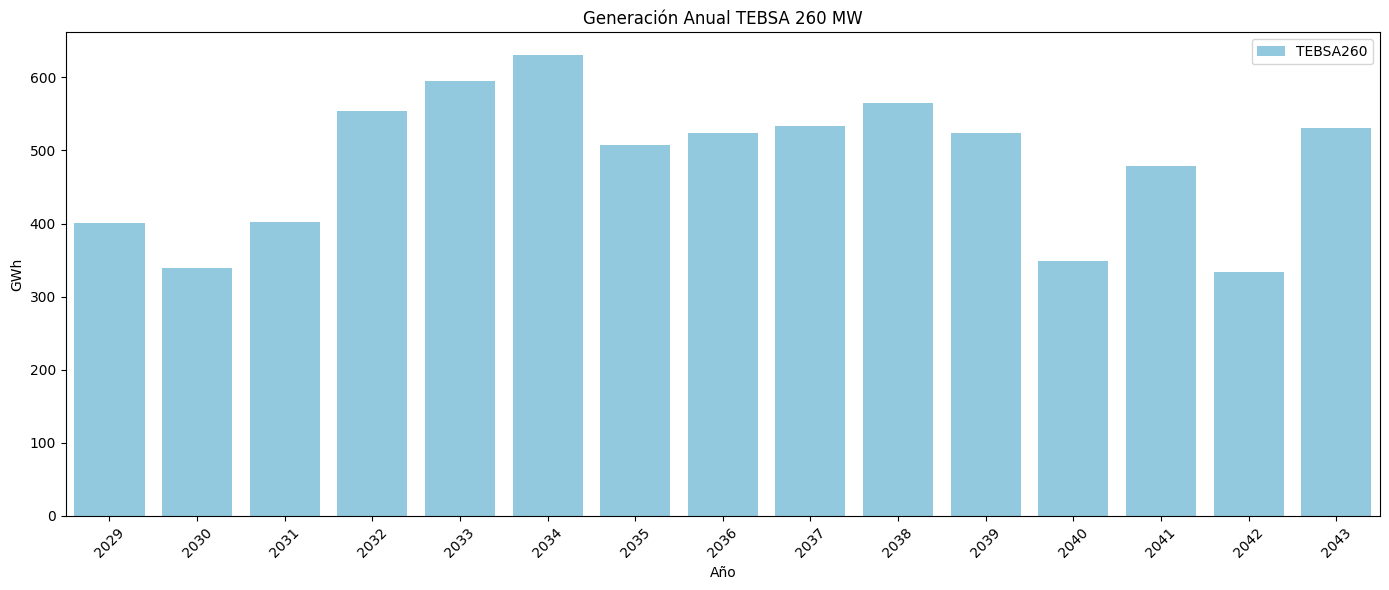

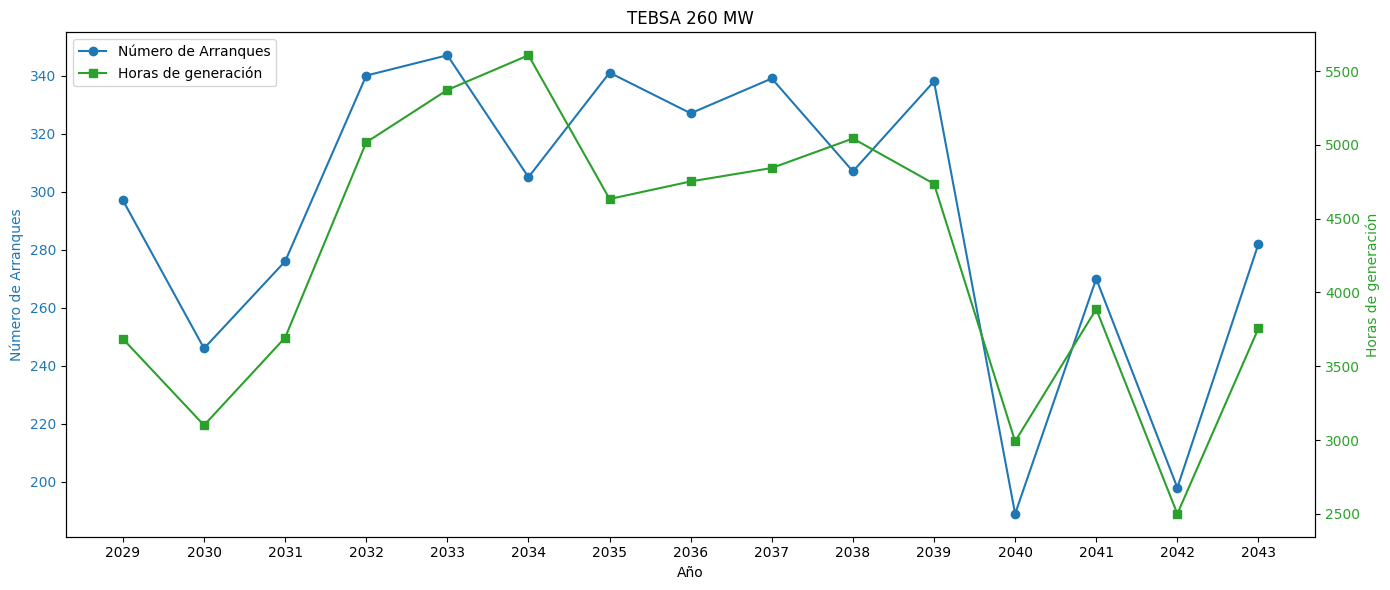

In [23]:
plt.figure(figsize=(14, 6))

# Gráfica de barras para TEBSA260
sns.barplot(data=df_data_per, x='year', y='TEBSA260', color='skyblue', label='TEBSA260')
plt.ylabel('GWh')
plt.xlabel('Año')
plt.title('Generación Anual TEBSA 260 MW')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfica de líneas para Arranques e IsGen
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Año')
ax1.set_ylabel('Número de Arranques', color=color)
ax1.set_xticks(df_data_per['year'])
ax1.plot(df_data_per['year'], df_data_per['Arranques'], marker='o', color=color, label='Número de Arranques')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Horas de generación', color=color)
ax2.plot(df_data_per['year'], df_data_per['IsGen'], marker='s', color=color, label='Horas de generación')
ax2.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('TEBSA 260 MW')
plt.tight_layout()
plt.show()